# Low Light to High Light Image Converter (Night Eye)
### Problem Statement:
- Predict a better lighting image from a given low/bad light image.

### Libraries

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
for device in tf.config.get_visible_devices('GPU'):
    tf.config.experimental.set_memory_growth(device, True)
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.applications import *
from tensorflow.keras.layers import *
from tensorflow.keras.regularizers import *
import os
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
import cv2
from skimage.io import imshow, imsave, imread
from skimage.transform import resize
import matplotlib.pyplot as plt
from tensorflow.keras.initializers import *
import tensorflow.keras.backend as K
import re
import collections
import warnings
warnings.filterwarnings('ignore')
tf.config.experimental_run_functions_eagerly(True)

In [2]:
train_dir = r'D:\Datasets\archive\flickr30k_images'
bs = 4
img_w = 256
img_h = 256
dim = (img_h, img_w, 3)

In [3]:
def reducer(img, value): # Light Reducer Function
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV) 
    hsv[...,2] = hsv[...,2]*value
    img = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    return img

In [4]:
def image_generator(batches): #Image Generator
    for batch in batches:
        batch_low = []
        for img in batch:
            value = np.random.uniform(0.1, 1, 1)[0]
            low_img = reducer(img, value)
            batch_low.append(low_img)
        batch_low = np.array(batch_low)
        yield batch_low, batch

In [127]:
def model_weight_utils(model, mode, weight_dir = None): # Function to load and save model in chunks to reduce the single file size
    ''' model: Trained or compiled model
        mode: To save weights: "save_weight"
              To load weights: "load_weight"
        weight_paths: Specify the path to saved weights (list)
        parts: Number of parts to split weights while sving the weights'''
    if mode.lower() == 'save_weight':
        weights = model.get_weights()
        for i in range(len(weights)):
            np.save((r'C:\Users\Lucifer MorningStar\Documents\DL\Low Light\Weights/weights_{}.npy'.format(i+1)), weights[i])
    
    if mode.lower() == 'load_weight':
        def clean(file):
            return int(re.findall('[0-9]+', file)[0])

        files = {}
        files = dict(zip(list(map((clean), os.listdir(weight_dir))), os.listdir(weight_dir)))
        files = list(collections.OrderedDict(sorted(files.items())).values())
        for i, file in enumerate(files):
            path = os.path.join(weight_dir, file)
            weights = np.load(path, allow_pickle=True)
            model.weights[i] = weights
            model.weights[i].assign(tf.reshape(weights, model.weights[i].numpy().shape))

In [135]:
train_gen = ImageDataGenerator(rescale = 1/255, validation_split = 0.26) #Clean Image Generator

train = train_gen.flow_from_directory(train_dir, class_mode = None, target_size = (img_h, img_w), batch_size = bs,
                                      subset = 'training')

val = train_gen.flow_from_directory(train_dir, class_mode = None, target_size = (img_h, img_w), batch_size = bs,
                                  subset = 'validation')

train_data = image_generator(train)
val_data = image_generator(val)

Found 23520 images belonging to 1 classes.
Found 8263 images belonging to 1 classes.


In [136]:
samp_x, samp_y = next(image_generator(train))
samp_x.shape,samp_y.shape

((4, 256, 256, 3), (4, 256, 256, 3))

### Sample Images/Data

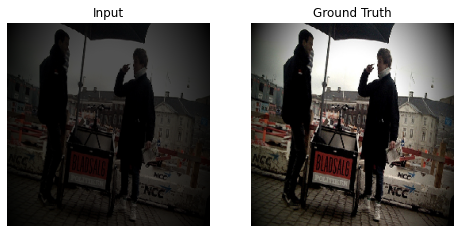

In [138]:
n = np.random.randint(0, len(samp_x),1)[0]
test = samp_x[n].reshape((1, img_h, img_w, 3))
pred = model.predict(test)[0]
pred = np.clip(pred, 0, 1)

fig, a = plt.subplots(1, 2)

a[0].set_title('Input')
a[0].imshow(samp_x[n])
a[0].axis('off')

a[1].set_title('Ground Truth')
a[1].imshow(samp_y[n])
a[1].axis('off')

fig.set_figwidth(8)
fig.set_figheight(8)
plt.show()

## Architecture and Utility Callbacks

#### Model Architecture

In [129]:
inp = Input(shape = dim)

conv1 = Conv2D(32, kernel_size = 5, padding = 'same', name='Conv_1', dilation_rate = 2)(inp)
conv1 = BatchNormalization()(conv1)
conv1 = LeakyReLU()(conv1)
conv2 = Conv2D(32, kernel_size = 5, padding = 'same', name='Conv_2', dilation_rate = 3)(conv1)
conv2 = BatchNormalization()(conv2)
conv2 = LeakyReLU()(conv2)
pool1 = MaxPool2D(2, padding = 'same')(conv2)

conv3 = Conv2D(64, kernel_size = 5, padding = 'same', name='Conv_3', dilation_rate = 2)(pool1)
conv3 = BatchNormalization()(conv3)
conv3 = LeakyReLU()(conv3)
conv4 = Conv2D(64, kernel_size = 5, padding = 'same', name='Conv_4', dilation_rate = 3)(conv3)
conv4 = BatchNormalization()(conv4)
conv4 = LeakyReLU()(conv4)
pool2 = MaxPool2D(2, padding = 'same')(conv4)

conv5 = Conv2D(128, kernel_size = 5, padding = 'same', name='Conv_5', dilation_rate = 2)(pool2)
conv5 = BatchNormalization()(conv5)
conv5 = LeakyReLU()(conv5)
conv6 = Conv2D(128, kernel_size = 5, padding = 'same', name='Conv_6', dilation_rate = 3)(conv5)
conv6 = BatchNormalization()(conv6)
conv6 = LeakyReLU()(conv6)
pool3 = MaxPool2D(2, padding = 'same')(conv6)

conv7 = Conv2D(256, kernel_size = 5, padding = 'same', name='Conv_7', dilation_rate = 2)(pool3)
conv7 = BatchNormalization()(conv7)
conv7 = LeakyReLU()(conv7)
conv8 = Conv2D(256, kernel_size = 5, padding = 'same', name='Conv_8', dilation_rate = 3)(conv7)
conv8 = BatchNormalization()(conv8)
conv8 = LeakyReLU()(conv8)
pool4 = MaxPool2D(2, padding = 'same')(conv8)

###################################### Upsampling ############################

up1 = Conv2DTranspose(256, kernel_size = 5, strides = 2, padding = 'same',
                           kernel_initializer = TruncatedNormal())(pool4)
up1 = Concatenate()([conv8, up1])
up1 = BatchNormalization()(up1)
up1 = Conv2D(256, kernel_size = 5, padding = 'same')(up1)
up1 = LeakyReLU()(up1)
up1 = Conv2D(256, kernel_size = 5, padding = 'same')(up1)
up1 = LeakyReLU()(up1)

up2 = Conv2DTranspose(128, kernel_size = 5, strides = 2, padding = 'same',
                           kernel_initializer = TruncatedNormal())(up1)
up2 = Concatenate()([conv6, up2])
up2 = BatchNormalization()(up2)
up2 = Conv2D(128, kernel_size = 5, padding = 'same')(up2)
up2 = LeakyReLU()(up2)
up2 = Conv2D(128, kernel_size = 5, padding = 'same')(up2)
up2 = LeakyReLU()(up2)

up3 = Conv2DTranspose(64, kernel_size = 5, strides = 2, padding = 'same',
                           kernel_initializer = TruncatedNormal())(up2)
up3 = Concatenate()([conv4, up3])
up3 = BatchNormalization()(up3)
up3 = Conv2D(64, kernel_size = 5, padding = 'same')(up3)
up3 = LeakyReLU()(up3)
up3 = Conv2D(64, kernel_size = 5, padding = 'same')(up3)
up3 = LeakyReLU()(up3)

up4 = Conv2DTranspose(32, kernel_size = 5, strides = 2, padding = 'same',
                           kernel_initializer = TruncatedNormal())(up3)
up4 = Concatenate()([conv2, up4])
up4 = BatchNormalization()(up4)
up4 = Conv2D(32, kernel_size = 5, padding = 'same')(up4)
up4 = LeakyReLU()(up4)
up4 = Conv2D(32, kernel_size = 5, padding = 'same')(up4)
up4 = LeakyReLU()(up4)

out = Conv2D(3, kernel_size = 5, padding = 'same')(up4)

model = Model(inputs = inp, outputs = out)
optimizer = tf.keras.optimizers.Adam()
model.compile(loss = 'mse', optimizer = optimizer)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
Conv_1 (Conv2D)                 (None, 256, 256, 32) 2432        input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_48 (BatchNo (None, 256, 256, 32) 128         Conv_1[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu_64 (LeakyReLU)      (None, 256, 256, 32) 0           batch_normalization_48[0][0]     
____________________________________________________________________________________________

#### Utility Callback

In [8]:
class predict_disp(Callback): # A custom callback to display random sample of prediction during the training
    def __init__(self, data = False):
        super(predict_disp, self).__init__()
        self.data_x, self.data_y = data[0], data[1]
    def on_epoch_end(self, epoch, logs = None):
        train.reset()
        n = np.random.randint(0, bs, 1)[0]
        X = self.data_x[n]
        Y = self.data_y[n]
        X = tf.expand_dims(X, 0)
        pred = self.model.predict(X)[0]
        res = tf.concat([X[0], pred, Y], 1)
        res = res.numpy()
        res = np.clip(res, 0, 1)
        plt.figure(figsize = (10, 6))
        imshow(res)
        plt.axis('off')
        plt.show()

### Training

In [ ]:
disp = predict_disp([samp_x, samp_y])
early = EarlyStopping(patience = 3, restore_best_weights = True)
check = ModelCheckpoint('model2.h5', save_best_only = True)
model.fit(train_data, epochs = 100, validation_data = (val_data), steps_per_epoch = 100, validation_steps = 30,
              callbacks = [disp, check])

### Evalutation

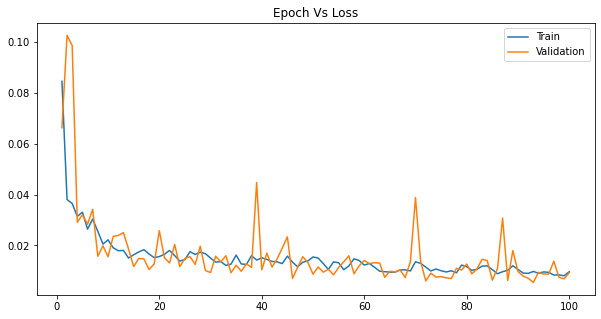

In [10]:
plt.figure(figsize = (10,5))
train_losses, val_losses = model.history.history['loss'], model.history.history['val_loss']

plt.plot(list(range(1, len(train_losses)+1)), train_losses, label = 'Train')
plt.plot(list(range(1, len(train_losses)+1)), val_losses, label = 'Validation')
plt.legend()
plt.title('Epoch Vs Loss')

plt.show()

In [23]:
model_weight_utils(model = model, mode = 'save_weight')

In [130]:
model_weight_utils(model = model, mode = 'load_weight', weight_dir = r'C:\Users\Lucifer MorningStar\Documents\DL\Low Light\Weights')

## Testing

#### Testing on Validation Data

In [140]:
X, Y = next(val_data)

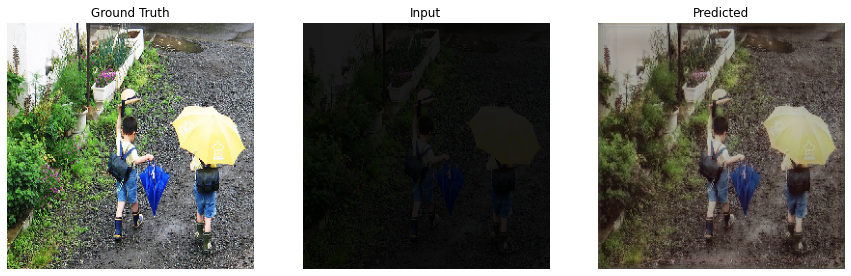

In [143]:
n = np.random.randint(0, len(X),1)[0]
test = X[n].reshape((1, img_h, img_w, 3))
pred = model.predict(test)[0]
pred = np.clip(pred, 0, 1)

fig, a = plt.subplots(1, 3)

a[0].set_title('Ground Truth')
a[0].imshow(Y[n])
a[0].axis('off')

a[1].set_title('Input')
a[1].imshow(X[n])
a[1].axis('off')

a[2].set_title('Predicted')
a[2].imshow(pred)
a[2].axis('off')

fig.set_figwidth(15)
fig.set_figheight(12)
plt.show()

#### Testing on Artificial Data with different Low Light Settings

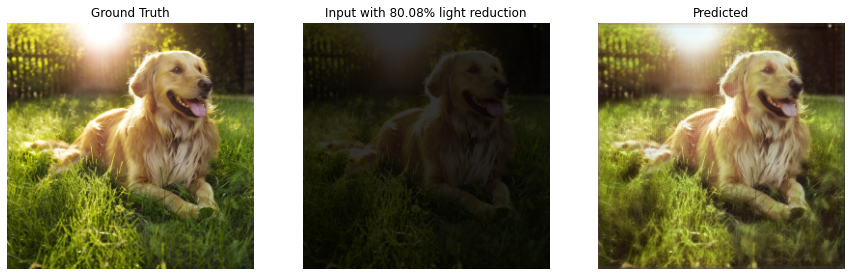

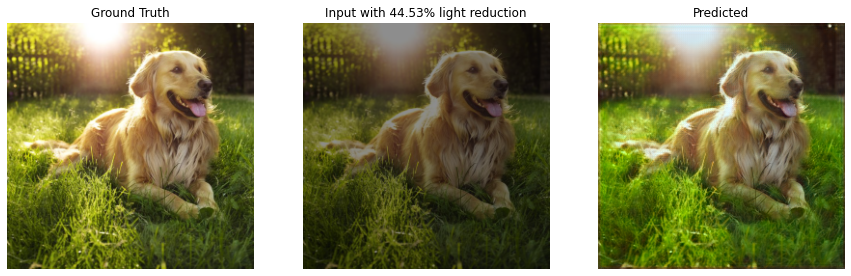

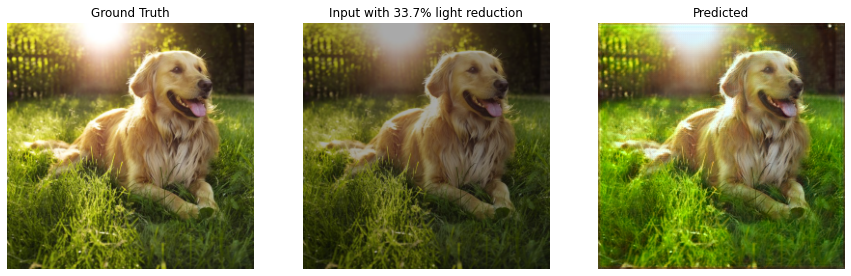

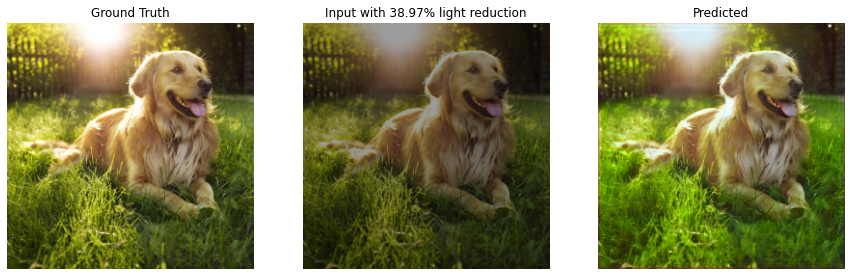

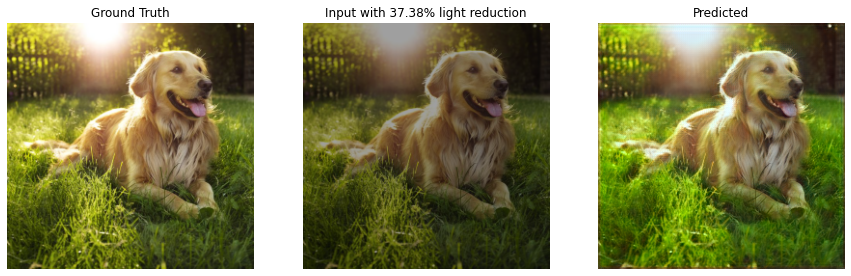

In [145]:
path = r'C:\Users\Lucifer MorningStar\Documents\DL\Low Light\dog.jpg'
for i in range(5):
    test_org = imread(path)/255
    test_org = img_to_array(test_org)
    test_org = resize(test_org, (img_h, img_w))
    value = np.random.uniform(0.1, 1, 1)[0]
    test = reducer(test_org, value)

    test = test.reshape((1, img_h, img_w, 3))
    pred = model.predict(test)[0]
    pred = np.clip(pred, 0, 1)

    f, a = plt.subplots(1, 3)

    f.set_figwidth(15)
    f.set_figheight(12)
    a[0].set_title('Ground Truth')
    a[0].imshow(test_org)
    a[0].axis('off')

    a[1].set_title('Input with {}% light reduction'.format(np.round((1-value)*100, 2)))
    a[1].imshow(test[0])
    a[1].axis('off')

    a[2].set_title('Predicted')
    a[2].imshow(pred)
    a[2].axis('off')

    f.show()

#### Testing on Real Low Light Image

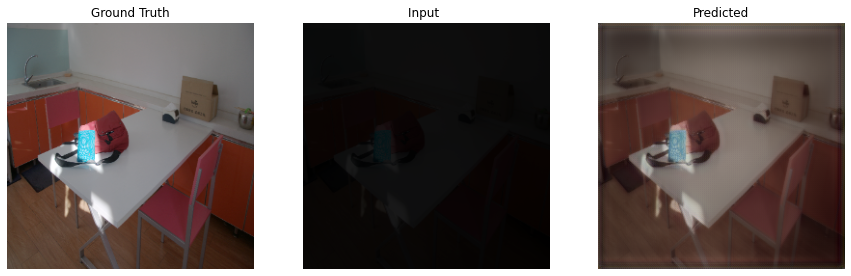

In [19]:
path_test = r'D:/Datasets/LOLdataset/our485/high/708.png'
path_gt = r'D:/Datasets/LOLdataset/our485/high/708.png'

test = imread(path_test)/255
test = resize(test, (img_h, img_w))
test = img_to_array(test)
test = reducer(test, 0.10)
gt = imread(path_gt)/255
gt = resize(gt, (img_h, img_w))

test = test.reshape((1, img_h, img_w, 3))
pred = model.predict(test)[0]
pred = np.clip(pred, 0, 1)

f, a = plt.subplots(1, 3)

f.set_figwidth(15)
f.set_figheight(12)
a[0].set_title('Ground Truth')
a[0].imshow(gt)
a[0].axis('off')

a[1].set_title('Input ')
a[1].imshow(test[0])
a[1].axis('off')

a[2].set_title('Predicted')
a[2].imshow(pred)
a[2].axis('off')

f.show()

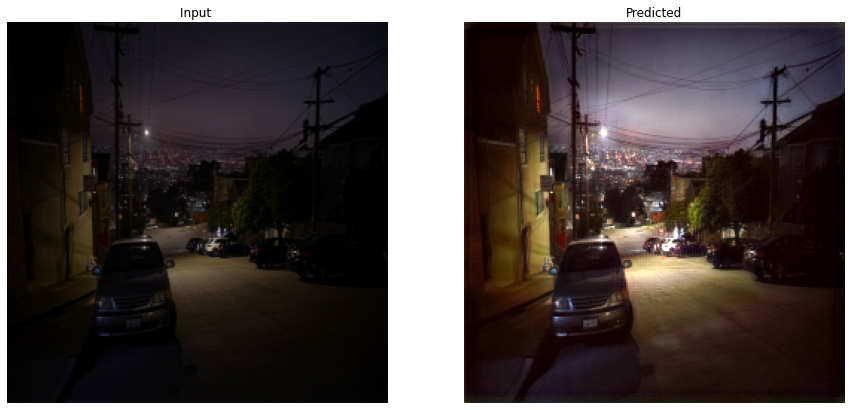

In [24]:
path_test = r'C:\Users\Lucifer MorningStar\Documents\DL\Low Light\zeta.jpg'

test = imread(path_test)/255
test = resize(test, (img_h, img_w))

test = test.reshape((1, img_h, img_w, 3))
pred = model.predict(test)[0]
pred = np.clip(pred, 0, 1)

f, a = plt.subplots(1, 2)

f.set_figwidth(15)
f.set_figheight(12)

a[0].set_title('Input ')
a[0].imshow(test[0])
a[0].axis('off')
a[1].set_title('Predicted')
a[1].imshow(pred)
a[1].axis('off')
f.show()